<a href="https://colab.research.google.com/github/cerfs21/notebooks/blob/main/Olivier_2_nnets_notebook_exercice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Networks tutorial


Hands-on tutorial: Neural Networks
Author: Dr. Habiboulaye {@gmail.com}

This hand-on tutorial will conver:
* Logistic Regression as a Single Layer NN
* Neural Networks from scratch

# 0. Populate the namespace
Please, do not modify the functions and codes of this section, just execute them before moving forward


### Useful packages

In [52]:
import numpy as np
from sklearn import datasets, linear_model
import pylab as plt
%matplotlib inline

### Utils

In [53]:
# function for displying/visualising the decision boundary of the ML model
def plot_decision_boundary(pred_func):
    """
        Function to plot a decision boundary.
    """
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

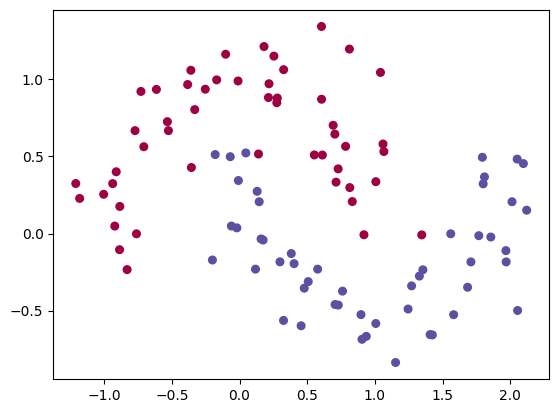

In [54]:
# Generate a dataset and plot it
np.random.seed(0)
X, y = datasets.make_moons(100, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=30, c=y, cmap=plt.cm.Spectral)

## DataSet

<font color='red'>
<b>EXERCICES</b>: Replace the <b>FILL_IN</b> pattern with the correct codes then execute the cell
 </font>

## 1. Single Layer NNet: Logistic Regression

First let's test Logistic Regression classifier as baseline estimator.
Find in [scikit-learn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model) the suitable package 'LogisticRegression'

In [55]:
# Import LogisticRegression classifier from sklearn.linear_models
from sklearn.linear_model import LogisticRegression
# Instantiate the LogisticRegression classifier using default parameters
clf = LogisticRegression()
# Train the logistic regression classifier
clf.fit(X, y)

LogisticRegression()

Text(0.5, 1.0, 'Logistic Regression')

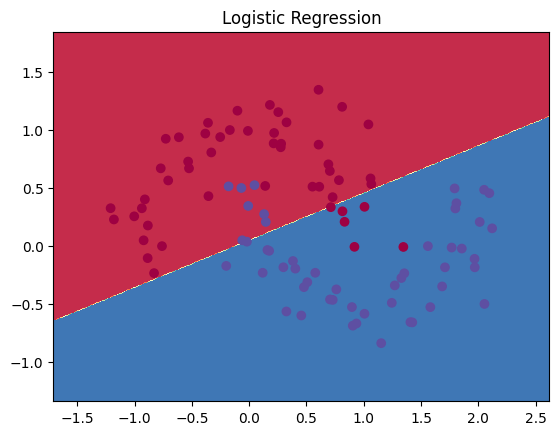

In [56]:
# Estimate the Logit decision boundary function using the classifier predictions
logit_decision_func = lambda x: clf.predict(x)
# Plot the decision boundary using the plot_decision_boundary function defined in section 0
plot_decision_boundary(logit_decision_func)
plt.title("Logistic Regression")

## 2. Two-layers Neural Networks: build from scratch
Implementing a network from scratch at least once is an extremely valuable exercise. It helps you gain an understanding of how neural networks work, and that is essential to designing effective models.

Design of our neural architecture:
* 2-layers neural network: 1-input layer, 1-hidden layer, and 1-output layer.
* Nombre of nodes: 2(=dim of data) nodes for input layer, 2(=nombre of classes) nodes for output (can use only 1 output node predicting 0 or 1, but having 2 makes it easier to extend the network to more classes later)
* Free to choose the number of nodes of the hidden layer. More nodes into the hidden layer decribs more complex functions to fit data. But more computations and risk of overfitting. Good choice of the size of hidden layer always depends on your specific problem.
* Pick an activation function for our hidden layer. Nonlinear activation function is what allows us to fit nonlinear hypotheses. Common chocies for activation functions are tanh, the sigmoid function, or ReLUs. tanh performs quite well in many scenarios and has nice derivative property: $\tanh x$ is $1-\tanh^2 x$
* Pick activation function for the output to to output probabilities. softmax converts raw scores to probabilities

In [57]:
# training set size X
num_examples = len(X)

# Paramater of the networks
# Fill the number of neurons for input layer = input data dimension
nn_input_dim = 2
# Fill the number of neurons for output layer = the number of classes
nn_output_dim = 2
# nn_hdim: Number of nodes in the hidden layer (will be defined later as function parameter)
nn_hdim = 2

# Optimiser: Gradient descent parameters (Picked these by hand)
epsilon = 0.01 # learning rate for gradient descent
reg_lambda = 0.01 # regularization strength

◊ Function to predict an output via Forward propagation

In [58]:
def predict(model, X):
    """
        Function to predict an output (0 or 1)
    """
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    ## Forward propagation
    # Compute z1 = W1.X + b1 at the 1st layer (numpy: The dot product of U by V is computed as V.dot(U) )
    z1 = np.dot(X,W1) + b1
    # Apply activation function tanh to comput the outout of the 1st layer (numpy: tanh of U is computed as np.tanh(U))
    a1 = np.tanh(z1)
    # Compute z2 the 2nd layer using the output of the 1st layer
    z2 = np.dot(z1,W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

◊ Loss function to evaluate how well our model

In [59]:
def calculate_loss(model, X):
    """
        Function to evaluate the total loss on the dataset
    """
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation to calculate our predictions
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # Calculating the loss
    correct_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(correct_logprobs)
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss

◊ Function to train the Neural Network. It implements batch gradient descent using the backpropagation derivates.

In [60]:
def build_model(nn_hdim, num_passes=20000, print_loss=False):
    """
        Function to learn parameters for the neural network and returns the model.
        - nn_hdim: Number of nodes in the hidden layer
        - num_passes: Number of passes through the training data for gradient descent
        - print_loss: If True, print the loss every 1000 iterations
    """
    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = {}

    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # Backpropagation
        delta3 = probs
        delta3[range(num_examples), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)

        # Add regularization terms (b1 and b2 don't have regularization terms)
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1

        # Gradient descent: parameter update by decreasing eaching with an epsilon portion of the corresponding gradient
        W1 -= epsilon*dW1
        b1 -= epsilon*db1
        W2 -= epsilon*dW2
        b2 -= epsilon*db2

        # Assign the new parameters to the model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, calculate_loss(model, X)))

    return model

### Train a network with a hidden layer size of 2.

Loss after iteration 0: 0.680410
Loss after iteration 1000: 0.081267
Loss after iteration 2000: 0.077295
Loss after iteration 3000: 0.067666
Loss after iteration 4000: 0.284104
Loss after iteration 5000: 0.073632
Loss after iteration 6000: 0.065926
Loss after iteration 7000: 0.068489
Loss after iteration 8000: 0.061620
Loss after iteration 9000: 0.066339
Loss after iteration 10000: 0.062100
Loss after iteration 11000: 0.259438
Loss after iteration 12000: 0.060949
Loss after iteration 13000: 0.168208
Loss after iteration 14000: 0.065834
Loss after iteration 15000: 0.294966
Loss after iteration 16000: 0.251320
Loss after iteration 17000: 0.064011
Loss after iteration 18000: 0.276620
Loss after iteration 19000: 0.062369


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 2')

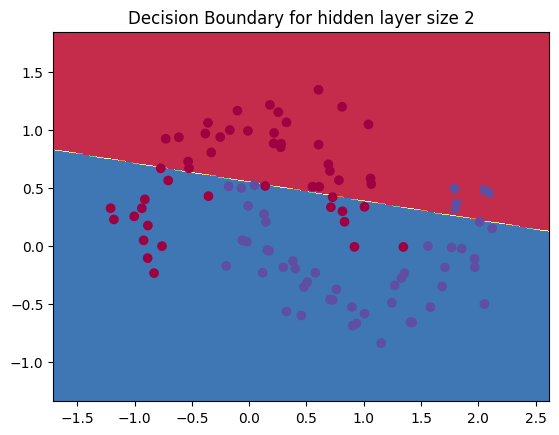

In [61]:
# Build a model with a 2-dimensional hidden layer (nb of neurons of the hidden layer)
model = build_model(nn_hdim=2, print_loss=True)
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 2")

### Tune the size of hidden layer

Loss after iteration 0: 0.596563
Loss after iteration 1000: 0.301146
Loss after iteration 2000: 0.301108
Loss after iteration 3000: 0.301077
Loss after iteration 4000: 0.301051
Loss after iteration 5000: 0.301030
Loss after iteration 6000: 0.301013
Loss after iteration 7000: 0.300998
Loss after iteration 8000: 0.300987
Loss after iteration 9000: 0.300977
Loss after iteration 10000: 0.300970
Loss after iteration 11000: 0.300963
Loss after iteration 12000: 0.300958
Loss after iteration 13000: 0.300954
Loss after iteration 14000: 0.300950
Loss after iteration 15000: 0.300947
Loss after iteration 16000: 0.300945
Loss after iteration 17000: 0.300943
Loss after iteration 18000: 0.300942
Loss after iteration 19000: 0.300940
Loss after iteration 0: 0.680410
Loss after iteration 1000: 0.081267
Loss after iteration 2000: 0.077295
Loss after iteration 3000: 0.067666
Loss after iteration 4000: 0.284104
Loss after iteration 5000: 0.073632
Loss after iteration 6000: 0.065926
Loss after iteration 700

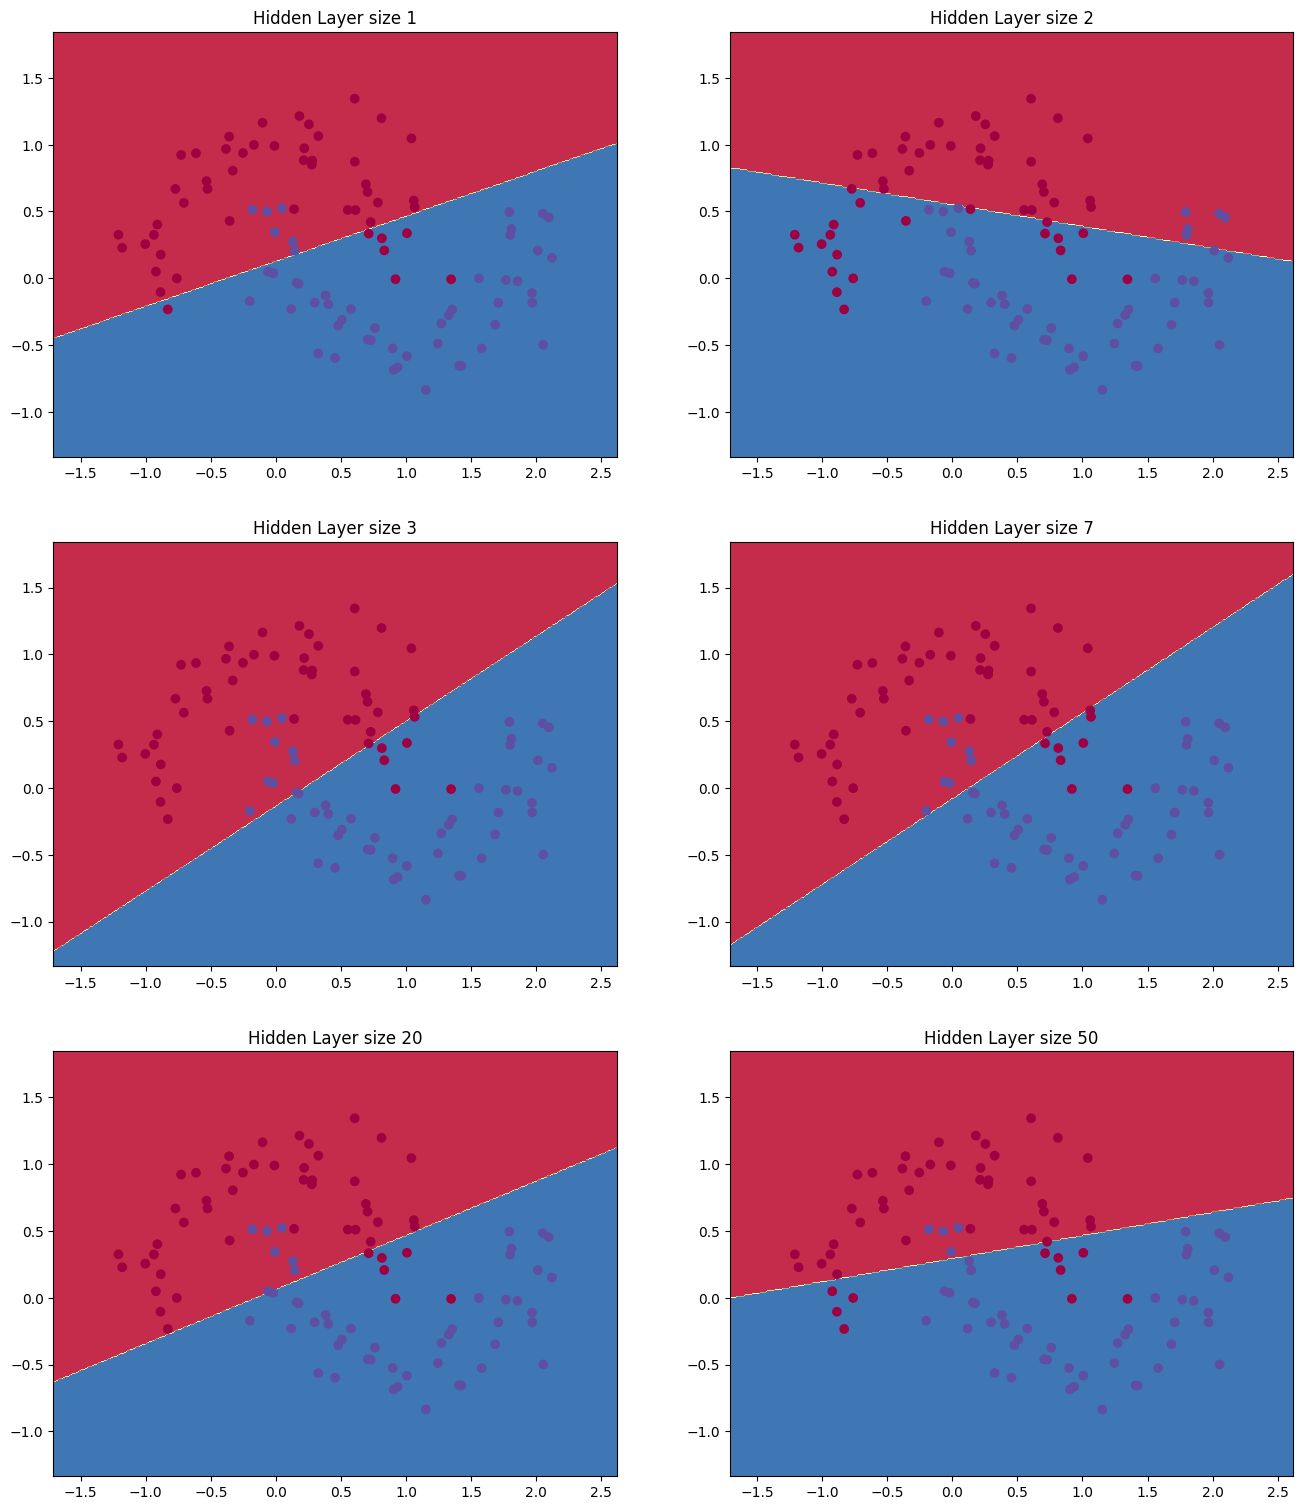

In [62]:
plt.figure(figsize=(16, 32))
# Varie the size of the hidden layer (nb of neurons) and observe the influence of this parameter
hidden_layer_dimensions = [1, 2, 3, 7, 20, 50]
for i, nn_hdim in enumerate(hidden_layer_dimensions):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer size %d' % hidden_layer_dimensions[i])
    model = build_model(nn_hdim, print_loss=True)
    plot_decision_boundary(lambda x: predict(model, x))
plt.show()

Conclusion ?